# Datos simulados de estabilidad de la red eléctrica

In [45]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from sklearn.utils import resample 
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing 
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.decomposition import PCA 

Okay, comenzaremos con el siguiente dataset que encontramos en [UCI](https://archive.ics.uci.edu/dataset/471/electrical+grid+stability+simulated+data), las caracteristicas nos dicen lo siguiente según la presentación de [Slideshare](https://www.learnpytorch.io/).
$$
\tau[x] : \text{Tiempo de reacción del participante en un rango de 0.5 a 10 segundos.}
\\
p[x]: \text{Poder nominal consumido o producido}
\\
g[x]: \text{Coeficiente proporcional a la elasticidad del precio en un rango de 0.05 a 1} s^{-1}
\\
\text{stab: La parte real máxima de la raiz de la ecuación caracteristica, si es positiva el sistema es}
\\
\text{
linealmente inestable. }
$$

El proposito de está notebook  es hacer uso una Maquina de Soporte Vectorial para clasificar los datos en sus respectivas clases (estable o inestable).

A su vez se va a hacer uso de Optimización de parametros para dar a relucir lo bien que sirven las MSV desde su primer uso.


In [46]:
#Comenzamos creando un dataframe con los datos
df = pd.read_csv('ELECTRODATA\Data_for_UCI_named.csv', 
                 header=None)

In [47]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
1,2.95906002455997,3.07988520422811,8.38102539191882,9.78075443222607,3.76308477206316,-0.782603630987543,-1.25739482958732,-1.7230863114883,0.650456460887227,0.859578105752345,0.887444920638513,0.958033987602737,0.0553474891727752,unstable
2,9.3040972346785,4.90252411201167,3.04754072762177,1.36935735529605,5.06781210427845,-1.94005842705193,-1.87274168559721,-1.25501199162931,0.41344056837935,0.862414076352903,0.562139050527675,0.781759910653126,-0.00595746432603695,stable
3,8.97170690932022,8.84842842134833,3.04647874898866,1.21451813833956,3.40515818001095,-1.20745559234302,-1.27721014673295,-0.92049244093498,0.163041039311334,0.766688656526962,0.839444015400588,0.109853244952427,0.00347087904838871,unstable
4,0.716414776295121,7.66959964406565,4.48664083058949,2.34056298396795,3.96379106326633,-1.02747330413905,-1.9389441526466,-0.997373606480681,0.446208906537321,0.976744082924302,0.929380522872661,0.36271777426931,0.028870543444887,unstable


In [48]:
#Aqui nos damos cuenta de que necesitamos "limpiar" los datos.
df.columns = ["tau1","tau2","tau3","tau4","p1","p2","p3","p4","g1","g2","g3","g4","stab","Estabilidad"] #los etiquetamos 
dflimpio = df.drop(index=0).copy() #eliminamos la primera fila que no tiene datos y solo estorba
dflimpio.rename({'stabf' : 'Estabilidad'}, axis='columns', inplace=True) #renombramos la columna de estabilidad
dflimpio.Estabilidad = dflimpio.Estabilidad.eq('unstable').mul(1) #Aquí le ponemos 1 a unstable y 0 a stable
X = dflimpio.drop('Estabilidad', axis=1).copy() 
y = dflimpio['Estabilidad'].copy()

In [49]:
X.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
1,2.95906002455997,3.07988520422811,8.38102539191882,9.78075443222607,3.76308477206316,-0.782603630987543,-1.25739482958732,-1.7230863114883,0.650456460887227,0.859578105752345,0.887444920638513,0.958033987602737,0.0553474891727752
2,9.3040972346785,4.90252411201167,3.04754072762177,1.36935735529605,5.06781210427845,-1.94005842705193,-1.87274168559721,-1.25501199162931,0.41344056837935,0.862414076352903,0.562139050527675,0.781759910653126,-0.00595746432603695
3,8.97170690932022,8.84842842134833,3.04647874898866,1.21451813833956,3.40515818001095,-1.20745559234302,-1.27721014673295,-0.92049244093498,0.163041039311334,0.766688656526962,0.839444015400588,0.109853244952427,0.00347087904838871
4,0.716414776295121,7.66959964406565,4.48664083058949,2.34056298396795,3.96379106326633,-1.02747330413905,-1.9389441526466,-0.997373606480681,0.446208906537321,0.976744082924302,0.929380522872661,0.36271777426931,0.028870543444887
5,3.13411155161342,7.60877161603408,4.94375930178099,9.85757326996638,3.52581081652096,-1.12553095451115,-1.84597485447561,-0.554305007534195,0.797109525792467,0.455449947148291,0.656946658473716,0.820923486481631,0.0498603734837059


In [50]:
y.head()

1    1
2    0
3    1
4    1
5    1
Name: Estabilidad, dtype: int32

In [51]:
len(dflimpio) #su maquina, está gigante la base de datos

10000

In [52]:
dflimpio.Estabilidad.value_counts() #no más queria ver 

Estabilidad
1    6380
0    3620
Name: count, dtype: int64

In [53]:
#Volvemos a etiquetar, reducimos el tamaño de lo que vamos a usar
#y volvemos a unir los datos

df_estable = dflimpio[dflimpio['Estabilidad'] == 0]
df_inestable = dflimpio[dflimpio['Estabilidad'] == 1]
df_estable_downsampled = resample(df_estable,
                                  replace=False, # es para que no volvamos a uar los mismos datos
                                  n_samples=1000,
                                  random_state=42)
df_inestable_downsampled = resample(df_inestable,
                                  replace=False,
                                  n_samples=1000,
                                  random_state=42)
df_downsample = pd.concat([df_estable_downsampled, df_inestable_downsampled]) #listo

In [54]:
#Separamos los datos en X y y, es decir, las inputs y las outputs (lo que queremos predecir)
X = df_downsample.drop('Estabilidad', axis=1).copy() 
y = df_downsample['Estabilidad'].copy()

In [55]:
#Separamos los datos en training y testing
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train) #estandarizamos los datos
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [56]:
clf_svm = SVC(random_state=42) #creamos el clasificador
clf_svm.fit(X_train_scaled, y_train) #entrenamos el clasificador

SVC(random_state=42)

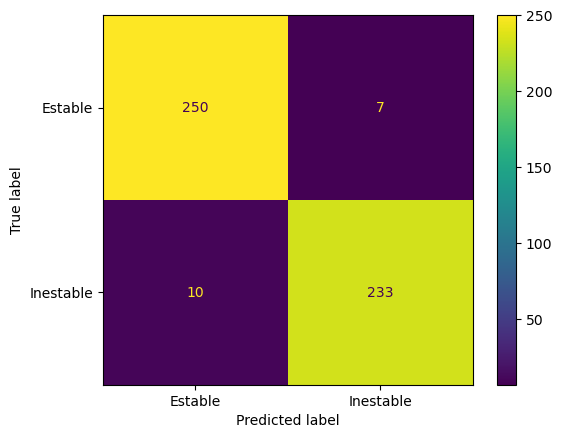

In [57]:
#Hacemos una predicción y visualizamos su desempeño con una matriz de confusión.
ConfusionMatrixDisplay.from_estimator(clf_svm, 
                                      X_test_scaled, 
                                      y_test,
                                      values_format='d',
                                      display_labels=["Estable", "Inestable"])       
                                                        

In [58]:
y_test.value_counts()
#Vemos que no le fue tan mal a nuestro SVM, pero podemos mejorar su desempeño (¿o no?)

Estabilidad
0    257
1    243
Name: count, dtype: int64

In [59]:
param_grid = [
  {'C': [0.5, 1, 10, 100], 
   'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
   'kernel': ['rbf']},
]
optimal_params = GridSearchCV(
        SVC(), 
        param_grid,
        cv=5,
        scoring='accuracy', 
        verbose=2
    )
optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.5, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.5, gamma=0.

In [60]:
clf_svm = SVC(random_state=42, C=100, gamma=0.001)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.001, random_state=42)

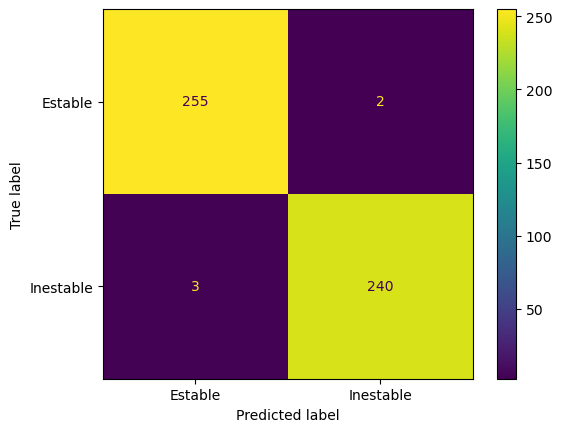

In [61]:
ConfusionMatrixDisplay.from_estimator(clf_svm, 
                                      X_test_scaled, 
                                      y_test,
                                      values_format='d',
                                      display_labels=["Estable", "Inestable"])